In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.transformations.compose import FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv('daily-website-visitors.csv')[["Date", "Page.Loads"]].rename(columns={"Date": 'ds', "Page.Loads": 'y'})

In [4]:
df['ds'] = pd.to_datetime(df.ds, yearfirst = True)

df['y'] = df.y.str.replace(',','.').astype("float")

df = df.set_index('ds')

In [5]:
y_train, y_test = temporal_train_test_split(df, test_size=365)
index_train, index_test = y_train.index, y_test.index

In [6]:
def inverse_transform(pipeline, X_transformed):
    # Iterate over the steps in reverse order
    for name, transformer in reversed(pipeline.steps):
        X_transformed = transformer.inverse_transform(X_transformed)
    return X_transformed

In [7]:
transform = Pipeline(
    steps=[
        ("imputer", Imputer(method="drift")),
        ("log", LogTransformer(offset=1)),
#        ("differencer", Differencer(lags=1)),
        ("scale", TabularToSeriesAdaptor(StandardScaler())),
    ]
)

window_summarizer = WindowSummarizer(
    lag_feature={
        "lag": list(range(1, 15)),
        "mean": [[2, 7], [1, 14]],
        "std": [[2, 7], [1, 14]],
    }
)

fourier_featurizer = FourierFeatures(sp_list=[365.25, 7], fourier_terms_list=[10, 2], freq='D')

featurizer = FeatureUnion([window_summarizer, fourier_featurizer])

In [8]:
y_train_transform = transform.fit_transform(y_train)
y_full_transform = y_train_transform.reindex(y_train_transform.index.union(y_test.index))
X_full = featurizer.fit_transform(y_full_transform)

In [9]:
lag_features = [f"WindowSummarizer__y_lag_{i}" for i in window_summarizer.lag_feature["lag"]]
mean_features = [f"WindowSummarizer__y_mean_{start}_{end}" for start, end in window_summarizer.lag_feature["mean"]]
std_features = [f"WindowSummarizer__y_std_{start}_{end}" for start, end in window_summarizer.lag_feature["std"]]
fourier_features = [f"FourierFeatures__{fn}_{per}_{i}" for per, freq in zip(fourier_featurizer.sp_list, fourier_featurizer.fourier_terms_list) for i in range(1, freq + 1) for fn in ("cos", "sin")]

X_full = X_full[lag_features + mean_features + std_features + fourier_features]
X_train, X_test = X_full.loc[index_train], X_full.loc[index_test]

In [10]:
model = CatBoostRegressor(loss_function="RMSE", has_time=True)
model.fit(X_train, y_train_transform)

Learning rate set to 0.044935
0:	learn: 0.9676839	total: 168ms	remaining: 2m 47s
1:	learn: 0.9364726	total: 176ms	remaining: 1m 28s
2:	learn: 0.9070418	total: 183ms	remaining: 1m
3:	learn: 0.8800485	total: 192ms	remaining: 47.7s
4:	learn: 0.8531199	total: 201ms	remaining: 39.9s
5:	learn: 0.8283784	total: 209ms	remaining: 34.7s
6:	learn: 0.8036589	total: 217ms	remaining: 30.8s
7:	learn: 0.7799539	total: 226ms	remaining: 28.1s
8:	learn: 0.7560010	total: 234ms	remaining: 25.8s
9:	learn: 0.7325148	total: 244ms	remaining: 24.2s
10:	learn: 0.7118484	total: 253ms	remaining: 22.7s
11:	learn: 0.6913877	total: 261ms	remaining: 21.5s
12:	learn: 0.6724948	total: 277ms	remaining: 21s
13:	learn: 0.6546950	total: 284ms	remaining: 20s
14:	learn: 0.6382721	total: 294ms	remaining: 19.3s
15:	learn: 0.6209690	total: 303ms	remaining: 18.7s
16:	learn: 0.6043750	total: 311ms	remaining: 18s
17:	learn: 0.5899746	total: 322ms	remaining: 17.6s
18:	learn: 0.5746424	total: 329ms	remaining: 17s
19:	learn: 0.5598933

183:	learn: 0.1722768	total: 1.62s	remaining: 7.2s
184:	learn: 0.1718678	total: 1.63s	remaining: 7.19s
185:	learn: 0.1714693	total: 1.64s	remaining: 7.18s
186:	learn: 0.1711477	total: 1.65s	remaining: 7.16s
187:	learn: 0.1709633	total: 1.65s	remaining: 7.14s
188:	learn: 0.1706769	total: 1.66s	remaining: 7.12s
189:	learn: 0.1702710	total: 1.67s	remaining: 7.11s
190:	learn: 0.1699072	total: 1.67s	remaining: 7.09s
191:	learn: 0.1693952	total: 1.68s	remaining: 7.07s
192:	learn: 0.1691145	total: 1.69s	remaining: 7.05s
193:	learn: 0.1687405	total: 1.69s	remaining: 7.04s
194:	learn: 0.1684784	total: 1.7s	remaining: 7.03s
195:	learn: 0.1682139	total: 1.71s	remaining: 7.01s
196:	learn: 0.1679312	total: 1.72s	remaining: 7s
197:	learn: 0.1674500	total: 1.72s	remaining: 6.98s
198:	learn: 0.1672165	total: 1.73s	remaining: 6.96s
199:	learn: 0.1668799	total: 1.73s	remaining: 6.94s
200:	learn: 0.1664627	total: 1.74s	remaining: 6.92s
201:	learn: 0.1661571	total: 1.75s	remaining: 6.91s
202:	learn: 0.165

374:	learn: 0.1273941	total: 2.85s	remaining: 4.75s
375:	learn: 0.1272402	total: 2.86s	remaining: 4.75s
376:	learn: 0.1270576	total: 2.87s	remaining: 4.74s
377:	learn: 0.1268670	total: 2.87s	remaining: 4.73s
378:	learn: 0.1266536	total: 2.88s	remaining: 4.72s
379:	learn: 0.1264778	total: 2.88s	remaining: 4.71s
380:	learn: 0.1263525	total: 2.89s	remaining: 4.7s
381:	learn: 0.1261784	total: 2.9s	remaining: 4.68s
382:	learn: 0.1260649	total: 2.9s	remaining: 4.67s
383:	learn: 0.1258884	total: 2.91s	remaining: 4.67s
384:	learn: 0.1256948	total: 2.91s	remaining: 4.66s
385:	learn: 0.1255100	total: 2.92s	remaining: 4.65s
386:	learn: 0.1254013	total: 2.93s	remaining: 4.64s
387:	learn: 0.1251814	total: 2.93s	remaining: 4.63s
388:	learn: 0.1249978	total: 2.94s	remaining: 4.62s
389:	learn: 0.1248045	total: 2.95s	remaining: 4.61s
390:	learn: 0.1246739	total: 2.95s	remaining: 4.6s
391:	learn: 0.1245457	total: 2.96s	remaining: 4.59s
392:	learn: 0.1244329	total: 2.96s	remaining: 4.58s
393:	learn: 0.12

534:	learn: 0.1043116	total: 3.86s	remaining: 3.35s
535:	learn: 0.1041982	total: 3.86s	remaining: 3.35s
536:	learn: 0.1041181	total: 3.87s	remaining: 3.34s
537:	learn: 0.1039889	total: 3.88s	remaining: 3.33s
538:	learn: 0.1038463	total: 3.89s	remaining: 3.33s
539:	learn: 0.1037463	total: 3.9s	remaining: 3.32s
540:	learn: 0.1036647	total: 3.9s	remaining: 3.31s
541:	learn: 0.1035497	total: 3.91s	remaining: 3.3s
542:	learn: 0.1034841	total: 3.92s	remaining: 3.3s
543:	learn: 0.1033665	total: 3.93s	remaining: 3.29s
544:	learn: 0.1032309	total: 3.93s	remaining: 3.28s
545:	learn: 0.1032069	total: 3.94s	remaining: 3.27s
546:	learn: 0.1031026	total: 3.94s	remaining: 3.27s
547:	learn: 0.1029601	total: 3.95s	remaining: 3.26s
548:	learn: 0.1028334	total: 3.96s	remaining: 3.25s
549:	learn: 0.1026793	total: 3.96s	remaining: 3.24s
550:	learn: 0.1025656	total: 3.97s	remaining: 3.23s
551:	learn: 0.1024598	total: 3.98s	remaining: 3.23s
552:	learn: 0.1023770	total: 3.98s	remaining: 3.22s
553:	learn: 0.10

709:	learn: 0.0871753	total: 4.85s	remaining: 1.98s
710:	learn: 0.0871208	total: 4.86s	remaining: 1.97s
711:	learn: 0.0870453	total: 4.86s	remaining: 1.97s
712:	learn: 0.0869181	total: 4.87s	remaining: 1.96s
713:	learn: 0.0868473	total: 4.87s	remaining: 1.95s
714:	learn: 0.0867758	total: 4.88s	remaining: 1.95s
715:	learn: 0.0867148	total: 4.88s	remaining: 1.94s
716:	learn: 0.0866410	total: 4.89s	remaining: 1.93s
717:	learn: 0.0865410	total: 4.9s	remaining: 1.92s
718:	learn: 0.0864072	total: 4.9s	remaining: 1.92s
719:	learn: 0.0863627	total: 4.91s	remaining: 1.91s
720:	learn: 0.0862033	total: 4.91s	remaining: 1.9s
721:	learn: 0.0861287	total: 4.92s	remaining: 1.89s
722:	learn: 0.0860600	total: 4.92s	remaining: 1.89s
723:	learn: 0.0859988	total: 4.93s	remaining: 1.88s
724:	learn: 0.0859325	total: 4.93s	remaining: 1.87s
725:	learn: 0.0858506	total: 4.94s	remaining: 1.86s
726:	learn: 0.0857891	total: 4.94s	remaining: 1.86s
727:	learn: 0.0857201	total: 4.95s	remaining: 1.85s
728:	learn: 0.0

891:	learn: 0.0728228	total: 5.86s	remaining: 710ms
892:	learn: 0.0727272	total: 5.87s	remaining: 703ms
893:	learn: 0.0726092	total: 5.87s	remaining: 696ms
894:	learn: 0.0725290	total: 5.88s	remaining: 690ms
895:	learn: 0.0724717	total: 5.88s	remaining: 683ms
896:	learn: 0.0723462	total: 5.89s	remaining: 676ms
897:	learn: 0.0722903	total: 5.89s	remaining: 670ms
898:	learn: 0.0722271	total: 5.9s	remaining: 663ms
899:	learn: 0.0721673	total: 5.91s	remaining: 656ms
900:	learn: 0.0721032	total: 5.91s	remaining: 649ms
901:	learn: 0.0720722	total: 5.92s	remaining: 643ms
902:	learn: 0.0720040	total: 5.92s	remaining: 636ms
903:	learn: 0.0719453	total: 5.92s	remaining: 629ms
904:	learn: 0.0718851	total: 5.93s	remaining: 623ms
905:	learn: 0.0718266	total: 5.94s	remaining: 616ms
906:	learn: 0.0717571	total: 5.94s	remaining: 609ms
907:	learn: 0.0716748	total: 5.95s	remaining: 603ms
908:	learn: 0.0716171	total: 5.95s	remaining: 596ms
909:	learn: 0.0715375	total: 5.96s	remaining: 589ms
910:	learn: 0

In [11]:
for idx in index_test:
    y_tmp = y_full_transform.loc[idx-pd.DateOffset(14+1):idx]
    a = featurizer.transform(y_tmp).loc[idx, lag_features+mean_features+std_features]
    X_test.loc[idx, lag_features+mean_features+std_features] = a
    y_full_transform.loc[idx] = model.predict(X_test.loc[idx])
    
y_pred = inverse_transform(transform, y_full_transform.loc[index_test])

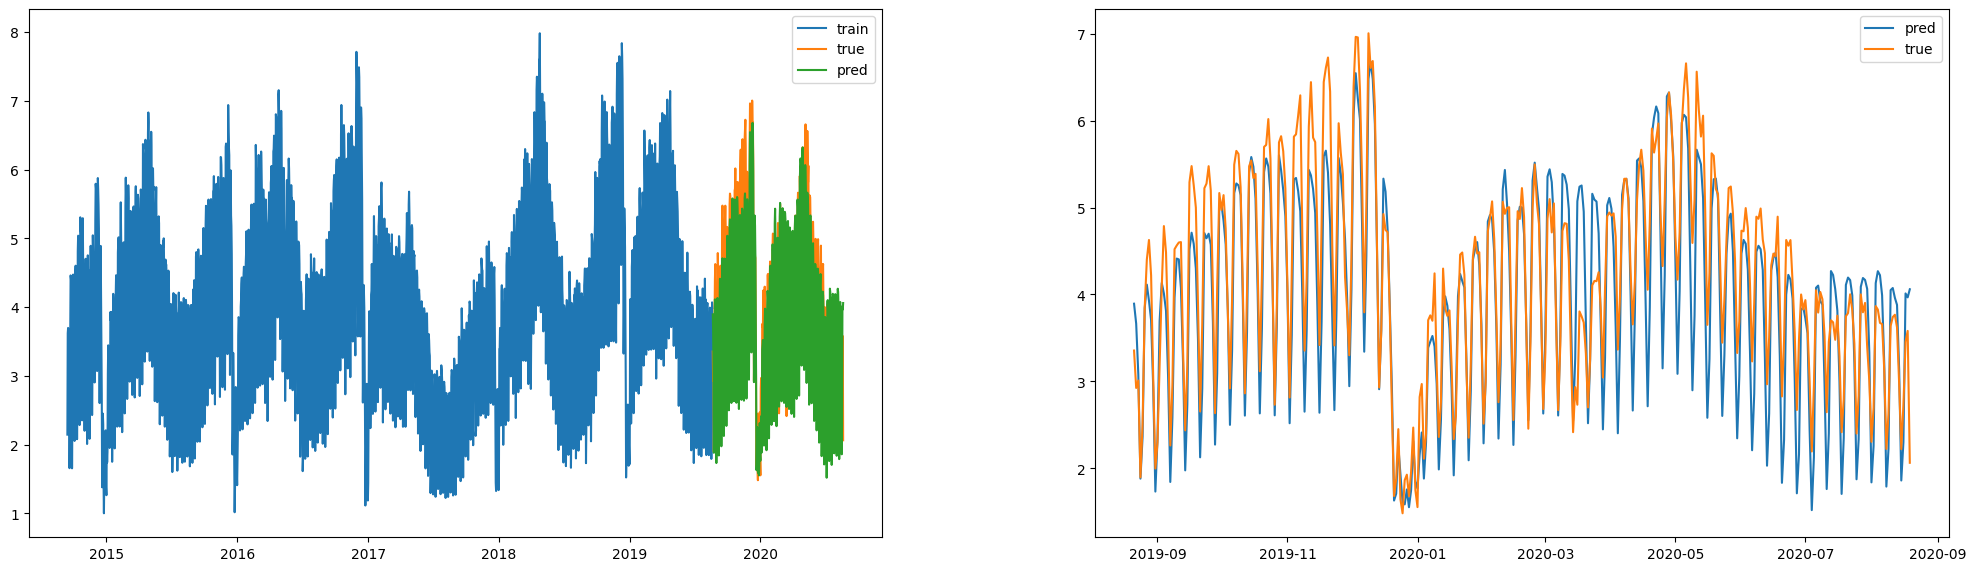

In [12]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)

ax0.plot(y_train.index, y_train.y, label='train')
ax0.plot(y_test.index, y_test.y, label='true')
ax0.plot(y_pred.index, y_pred.y, label='pred')
ax0.legend()

ax1.plot(y_pred.index, y_pred.y, label='pred')
ax1.plot(y_test.index, y_test.y, label='true')
ax1.legend()

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

In [13]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.3115621128534672
MAPE: 0.110725265772048


In [14]:
#shape